##### Let's get started....

## Importing necessary libraries

In [1]:
!pip install torchsummary
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta

In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import gradio as gr



%matplotlib inline

Loading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/data"
train_dir = "/content/drive/MyDrive/dataset/train"
valid_dir = "/content/drive/MyDrive/dataset/valid"
diseases = os.listdir(train_dir)

In [5]:
# printing the disease names
print(diseases)

['tp___healthy', 'tp___redleafspot']


In [6]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 2


In [7]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if 'healthy' not in plant:
      plants.append(plant.split('___')[0])
plants=list(set(plants))
NumberOfDiseases=1
print(plants)

['tp']


In [8]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
tp___healthy,73
tp___redleafspot,120


#### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

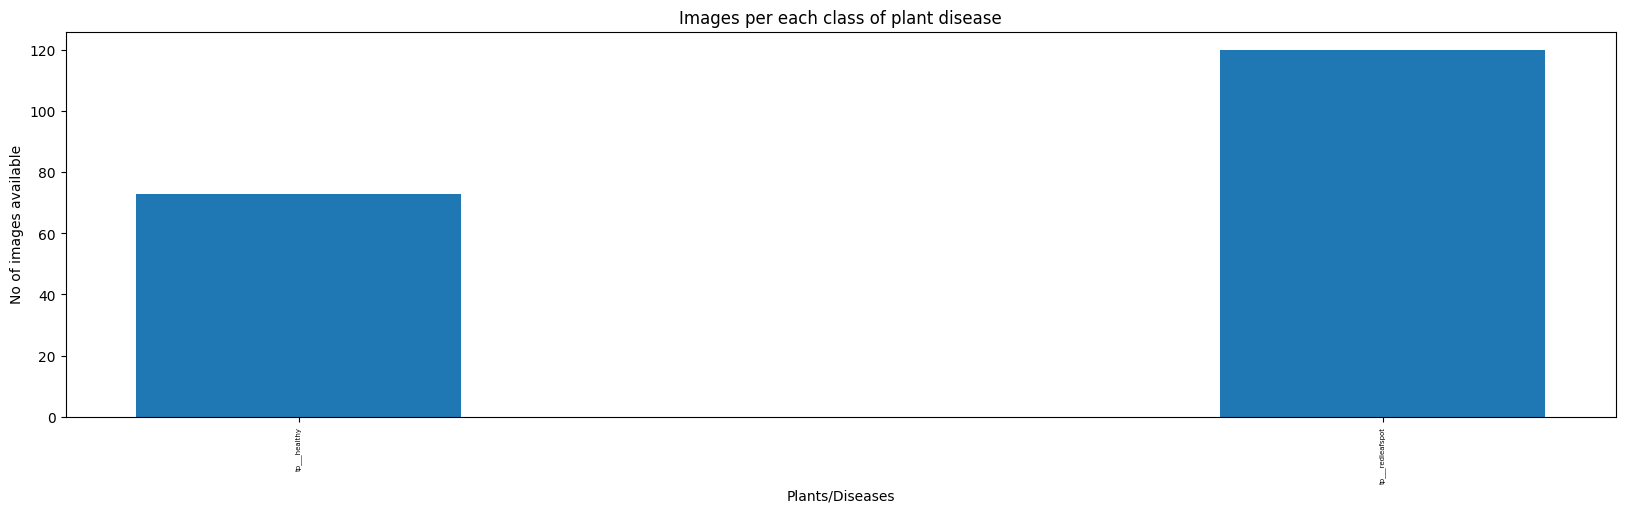

In [9]:
# plotting number of images available for each disease
index = [n for n in range(2)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [10]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 193 images for training


# 🍳 Data Preparation for training 🍳

In [11]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

`torchvision.datasets` is a class which helps in loading all common and famous datasets. It also helps in loading custom datasets. I have used subclass `torchvision.datasets.ImageFolder` which helps in loading the image data when the data is arranged in this way:

----------------
root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png

<br>

root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

----------------

Next, after loading the data, we need to transform the pixel values of each image (0-255) to 0-1 as neural networks works quite good with normalized data. The entire array of pixel values is converted to torch [tensor](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html#:~:text=A%20PyTorch%20Tensor%20is%20basically,used%20for%20arbitrary%20numeric%20computation.) and then divided by 255.
If you are not familiar why normalizing inputs help neural network, read [this](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) post.

#### Image shape

In [12]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 255, 255]) 0


We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

In [13]:
# total number of classes in train set
len(train.classes)

2

In [14]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

## 🖼️ Some Images from training dataset 🖼️

Label :tp___healthy(0)


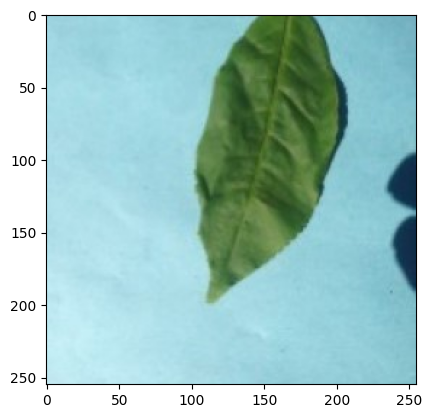

In [15]:
show_image(*train[0])

In [16]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [17]:
# setting the batch size
batch_size = 10

In [18]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

- `DataLoader` is a subclass which comes from `torch.utils.data`. It helps in loading large and memory consuming datasets. It takes in `batch_size` which denotes the number of samples contained in each generated batch.

- Setting `shuffle=True` shuffles the dataset. It is heplful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

- `num_workers`, denotes the number of processes that generate batches in parallel. If you have more cores in your CPU, you can set it to number of cores in your CPU. Since, Kaggle provides a 2 core CPU, I have set it to 2


In [19]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

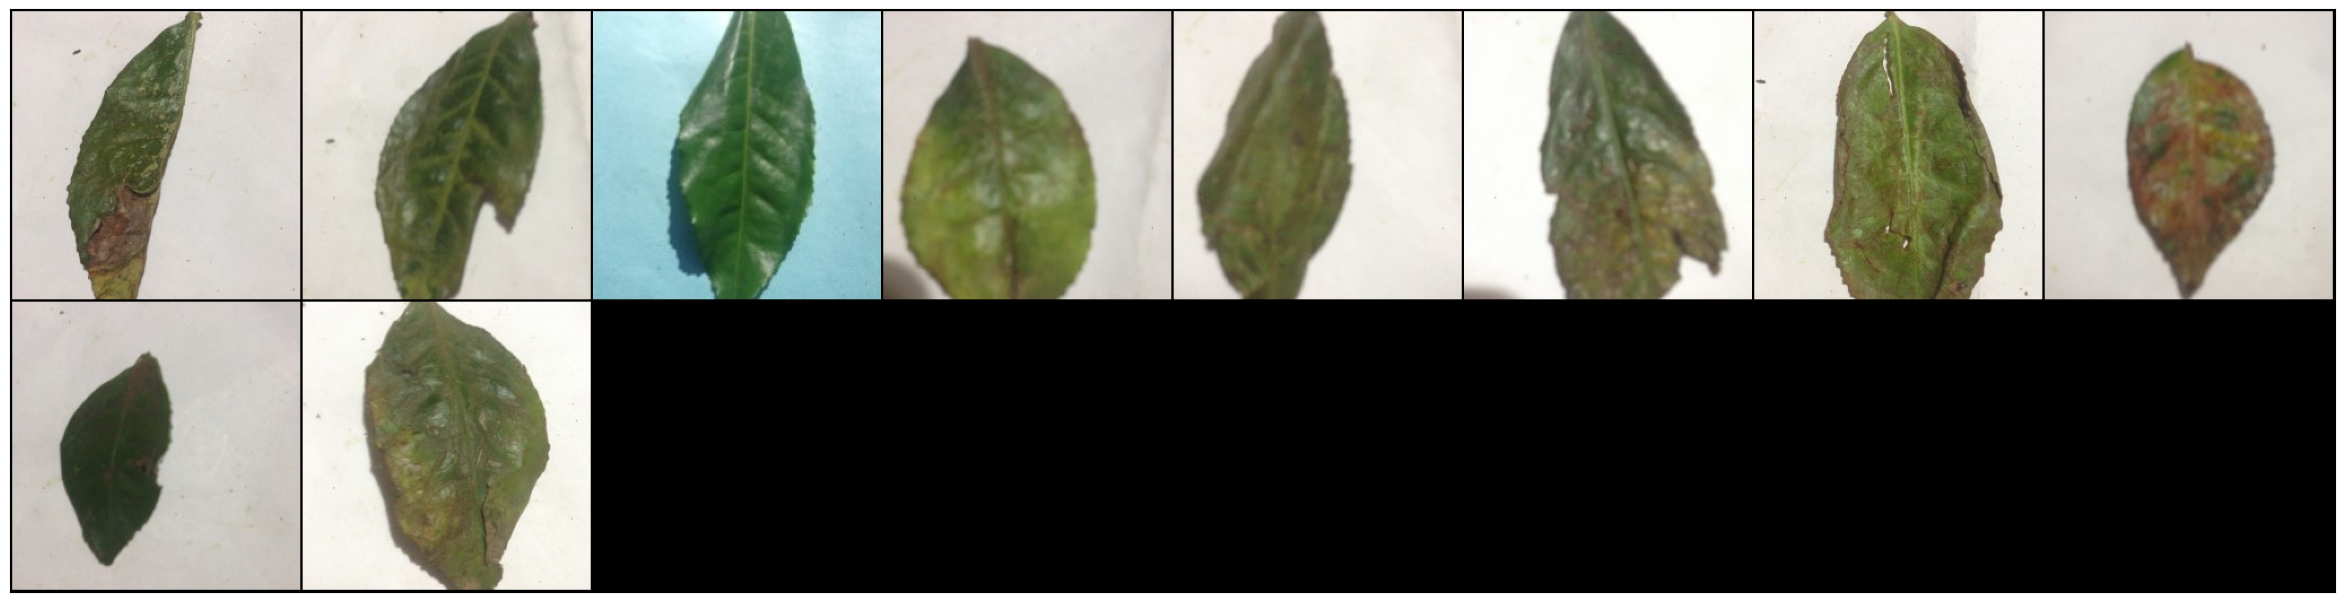

In [20]:
# Images for first batch of training
show_batch(train_dl)

In [21]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In ResNets, unlike in traditional neural networks, each layer feeds into the next layer, we use a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away, to avoid over-fitting (a situation when validation loss stop decreasing at a point and then keeps increasing while training loss still decreases). This also helps in preventing [vanishing gradient problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484) and allow us to train deep neural networks. Here is a simple residual block:

![image](https://www.mdpi.com/remotesensing/remotesensing-11-01896/article_deploy/html/images/remotesensing-11-01896-g001.png)

#### Residual Block code implementation

In [22]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [23]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


## 👷 Defining the final architecture of our model 👷

In [24]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2,stride=2))
    return nn.Sequential(*layers)



# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Now, we define a model object and transfer it into the device with which we are working...

In [25]:
# defining the model and moving it to the GPU
model = ResNet9(3, len(train.classes))
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [26]:
# getting summary of the model
INPUT_SHAPE = (3, 255, 255)


In [27]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

Let's check our validation loss and accuracy

In [28]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 32 s, sys: 9.63 s, total: 41.7 s
Wall time: 45.4 s


[{'val_loss': tensor(0.7022), 'val_accuracy': tensor(0.2250)}]

In [29]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

Note: The following cell may take 15 mins to 45 mins to run depending on your GPU. In kaggle (P100 GPU) it took around 20 mins of Wall Time.

In [30]:
history+=fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.2358, val_loss: 8.6485, val_acc: 0.2250
Epoch [1], last_lr: 0.00000, train_loss: 0.2581, val_loss: 0.0700, val_acc: 0.9750


### We got an accuracy of 99.2 % 🙌🙌

# 📈 Plotting 📈

#### Helper functions for plotting

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Validation Accuracy

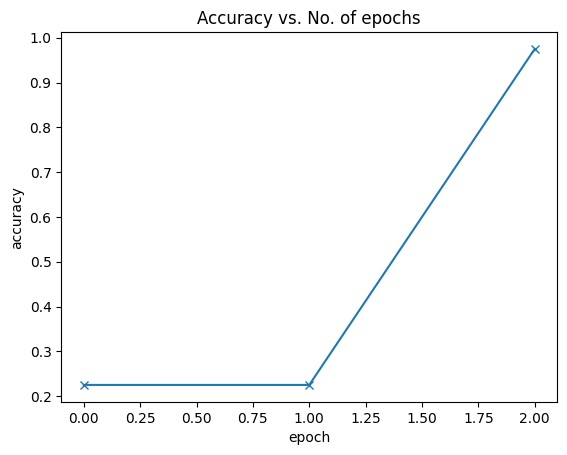

In [32]:
plot_accuracies(history)

## Validation loss

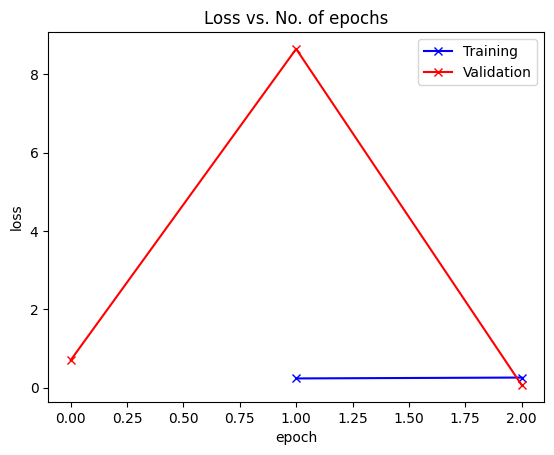

In [33]:
plot_losses(history)

## Learning Rate overtime

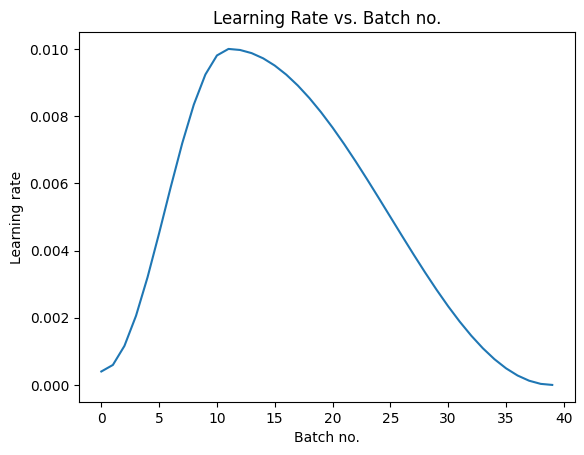

In [34]:
plot_lrs(history)

# 🧪 Testing model on test data 🧪

**We only have 33 images in test data, so let's check the model on all images**

In [35]:
test_dir = "/content/drive/MyDrive/dataset"
test = ImageFolder(test_dir,transform=transforms.ToTensor())

In [36]:
test_images = sorted(os.listdir(test_dir)) # since images in test folder are in alphabetical order
test_images

['train', 'valid']

In [39]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0),"cpu")
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]


In [46]:
def predict_disease(img):
    img = Image.fromarray((img * 255).astype('uint8'))  # Convert back to PIL Image
    img = transforms.ToTensor()(img).unsqueeze(0)  # Transform and add batch dimension
    img = to_device(img, "cpu")  # Move to CPU if using GPU
    prediction = predict_image(img, model)
    return prediction

# Gradio interface
iface = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    live=True,
    capture_session=True,
    title="Plant Disease Classification",
    description="Upload an image of a plant leaf to classify the disease.",
)

# Launch the Gradio interface
iface.launch()

TypeError: BlockContext.__init__() got an unexpected keyword argument 'capture_session'

Label: train , Predicted: tp___healthy


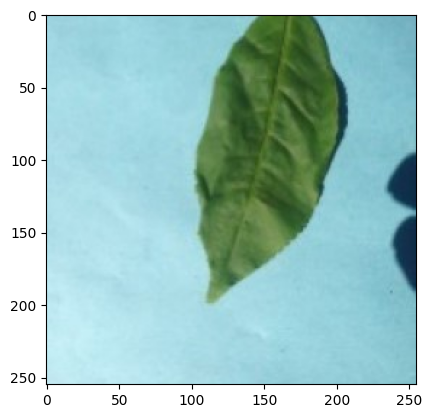

In [38]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

**We can see that the model predicted all the test images perfectly!!!!**